In [16]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
import pickle
import types
import io

In [2]:
def process_mimic_data():
    df_features = pd.read_csv('data/processed/features.csv')

    # List of temporal features to aggregate
    temporal_features = [
        'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2',
        'aniongap', 'albumin', 'bands', 'bicarbonate', 'bilirubin', 'creatinine',
        'chloride', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'platelet',
        'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'
    ]

    # Aggregate temporal data by computing summary statistics for each 'hadm_id'
    temporal_aggregated = df_features.groupby('hadm_id').agg({feature: ['mean', 'max', 'min'] for feature in temporal_features}).reset_index()

    # Flatten the multi-level columns after aggregation
    temporal_aggregated.columns = ['_'.join(col).strip() if col[1] else col[0] for col in temporal_aggregated.columns.values]

    # Load non-temporal data
    df_demo = pd.read_csv('data/processed/demo.csv')
    df_labels_icd = pd.read_csv('data/processed/labels_icd.csv')
    df_los = pd.read_csv('data/processed/los.csv')

    # Merge datasets on 'hadm_id'
    df_combined = df_demo.merge(temporal_aggregated, on='hadm_id', how='inner') \
                        .merge(df_labels_icd, on='hadm_id', how='inner') \
                        .merge(df_los, on='hadm_id', how='inner') 

    ######################## Remove columns with NaNs ########################
    # Calculate the number of NaNs in each column
    nan_counts = df_combined.isnull().sum()

    # Columns with NaNs
    columns_with_nans = nan_counts[nan_counts > 0].index.tolist()

    # Calculate the percentage of NaNs in each column
    nan_percentage = (nan_counts / len(df_combined)) * 100

    # Combine the counts and percentages into a DataFrame for better readability
    nan_summary = pd.DataFrame({'NaN Count': nan_counts, 'NaN Percentage': nan_percentage})

    # Print the number of columns before removing
    print(f"Number of columns before removing: {df_combined.shape[1]}")

    # Identify columns to remove where NaN percentage is greater than 50%
    columns_to_remove = nan_summary[nan_summary['NaN Percentage'] > 50].index.tolist()

    print("Columns with NaNs that will be kept", nan_summary[(nan_summary['NaN Percentage'] < 50) & (nan_summary['NaN Count'] != 0)].index.tolist())

    # Print the columns that will be removed
    print("Columns to be removed (NaN > 50%):", columns_to_remove)

    # Remove the identified columns
    df_combined = df_combined.drop(columns=columns_to_remove)

    # Print the number of columns after removing
    print(f"Number of columns after removing: {df_combined.shape[1]}")

    ######################## Create binary demographic variables before encoding ########################
    df_combined['is_white'] = df_combined['ethnicity'].str.startswith('WHITE').astype(int) #1 for white, 0 for non-white
    df_combined['gender_binary'] = (df_combined['gender'] == 'F').astype(int)  # 1 for female, 0 for male

    # Drop original demographic columns since we have binary versions
    df_combined = df_combined.drop(columns=['ethnicity', 'gender'])
    
    # Identify numerical features (excluding target, hadm_id, and demographic variables)
    numerical_features = df_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_features = [col for col in numerical_features 
                         if col not in ['los', 'hadm_id', 'is_white', 'gender_binary']]
    
    # Create binary target variable (1 if LOS > 5 days, 0 otherwise)
    y = (df_combined['los'] > 5).astype(int)
    X_train, X_test = train_test_split(df_combined, test_size=0.3, random_state=42, stratify=y)
    
    # Scale numerical features just using the train set
    scaler = StandardScaler()
    scaler.fit(X_train[numerical_features])
    df_combined[numerical_features] = scaler.transform(df_combined[numerical_features])
    
    # Get non-numeric columns for one-hot encoding (excluding already processed demographic features)
    non_numeric_columns = df_combined.select_dtypes(include=['object', 'category']).columns
    
    # Apply one-hot encoding to remaining categorical variables
    df_combined_encoded = pd.get_dummies(df_combined, columns=non_numeric_columns, dtype=int)
    
    print("Imputing missing values")
    # Identify columns with NaNs that are not removed
    columns_with_nans_to_impute = [col for col in columns_with_nans 
                                  if col not in columns_to_remove]
    
    # Perform KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    df_combined_encoded[columns_with_nans_to_impute] = imputer.fit_transform(
        df_combined_encoded[columns_with_nans_to_impute]
    )
    print("Imputing missing values done")
    
    # Print class distribution
    print("\nClass distribution:")
    print(f"Percentage of stays > 5 days: {(y == 1).mean():.2%}")
    print(f"Percentage of stays ≤ 5 days: {(y == 0).mean():.2%}")
    
    # Create two versions of features
    # 1. All features including demographic variables
    X_all = df_combined_encoded.drop(columns=['hadm_id', 'los'])
    
    # 2. Features without sensitive attributes
    X_without_sensitive = X_all.drop(columns=['gender_binary', 'is_white'])
    
    print(f"\nShape of X_all: {X_all.shape}")
    print(f"Shape of X_without_sensitive: {X_without_sensitive.shape}")
    
    return X_all, X_without_sensitive, y

X_all, X_without_sensitive, y = process_mimic_data()

Number of columns before removing: 106
Columns with NaNs that will be kept ['aniongap_mean', 'aniongap_max', 'aniongap_min', 'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_min', 'creatinine_mean', 'creatinine_max', 'creatinine_min', 'chloride_mean', 'chloride_max', 'chloride_min', 'glucose_mean', 'glucose_max', 'glucose_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'hemoglobin_mean', 'hemoglobin_max', 'hemoglobin_min', 'platelet_mean', 'platelet_max', 'platelet_min', 'potassium_mean', 'potassium_max', 'potassium_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'inr_mean', 'inr_max', 'inr_min', 'pt_mean', 'pt_max', 'pt_min', 'sodium_mean', 'sodium_max', 'sodium_min', 'bun_mean', 'bun_max', 'bun_min', 'wbc_mean', 'wbc_max', 'wbc_min']
Columns to be removed (NaN > 50%): ['heartrate_mean', 'heartrate_max', 'heartrate_min', 'sysbp_mean', 'sysbp_max', 'sysbp_min', 'diasbp_mean', 'diasbp_max', 'diasbp_min', 'meanbp_mean', 'meanbp_max', 'meanbp_min', 'resprate_mean', 'resprate_max',

<Axes: >

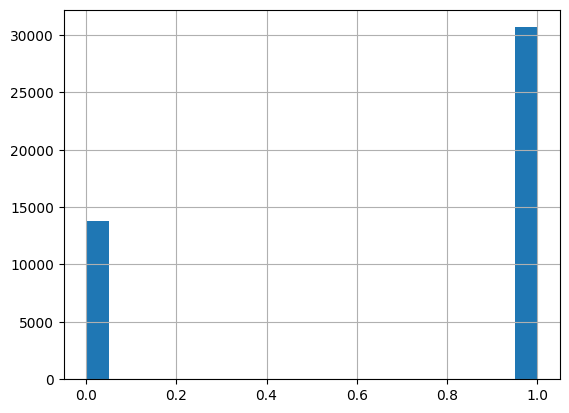

In [3]:
y.hist(bins=20)

In [4]:
# Define a neural network model with batch normalization and dropout
class DeeperNNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout_prob=0.2):
        super(DeeperNNWithBatchNorm, self).__init__()
        # Define layers with batch normalization and dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)

        self.fc4 = nn.Linear(hidden_dim3, 1)  # Single output for binary classification

    def forward(self, x):
        # Forward pass through layers with batch normalization, activation, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # Linear layer output
        return x

# Function to train the neural network model for binary classification
def train_neural_network_model(X_train, y_train, input_dim, lr=0.001, epochs=1000, hidden_dim1=512, hidden_dim2=256, hidden_dim3=64, dropout_prob=0.2):
    # Initialize the neural network model with specified dimensions and dropout
    model = DeeperNNWithBatchNorm(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_prob)
    
    # Use Binary Cross Entropy Loss with logits for binary classification
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss (handles sigmoid internally)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for better convergence
    
    # Convert training data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)  # Ensure y is of shape [batch_size, 1]
    
    # Store the loss values for visualization
    loss_values = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Zero gradients
        outputs = model(X_train_tensor)  # Forward pass
        
        # Compute loss (BCEWithLogitsLoss expects raw logits as input)
        loss = criterion(outputs, y_train_tensor)  
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update weights
        
        # Save loss value for each epoch
        loss_values.append(loss.item())

        # Optional: Print the loss every 100 epochs to monitor progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    # Plot the loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

In [5]:
def predict_classification_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        probabilities = model(X_tensor).squeeze()
        predictions = (probabilities >= 0.5).float()
    return predictions.numpy()

# Function to evaluate the neural network regression model
def evaluate_model_classification(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_classification_model(model, X_train)
    y_test_pred = predict_classification_model(model, X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Plot confusion matrix for test data
    test_cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(test_cm).plot()
    plt.title(f'Confusion Matrix - Test Data ({model_name})')
    plt.show()

    # Print accuracy results
    print(f"Training Accuracy {model_name}: {train_accuracy:.4f}")
    print(f"Test Accuracy {model_name}: {test_accuracy:.4f}")

In [6]:
# Function to train and evaluate models using the HSLS dataset
def train_and_evaluate_model():
    # Step 1: Process and prepare the HSLS data (assuming `df` is already loaded and cleaned)
    X_all, X_without_sensitive, y = process_mimic_data()

    # Step 2: Split the data into training and testing sets for both feature sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42, stratify=y)
    X_train_h0, X_test_h0 = train_test_split(X_without_sensitive, test_size=0.3, random_state=42, stratify=y)

    print("Running classification task")

    # Step 3: Train and evaluate model using all features (HP)
    print("Training and evaluating model with all features (HP)...")
    model_hp = train_neural_network_model(X_train_hp, y_train, X_train_hp.shape[1], lr=0.001, epochs=700)
    evaluate_model_classification(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")

    # Step 4: Train and evaluate model excluding sensitive attributes (H0)
    print("\nTraining and evaluating model excluding sensitive attributes (H0)...")
    model_h0 = train_neural_network_model(X_train_h0, y_train, X_train_h0.shape[1], lr=0.001, epochs=700)
    evaluate_model_classification(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    # Step 5: Return the necessary objects
    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0

In [7]:
def create_gender_race_filters(X_test):
    """
    Create filters for the four groups based on combinations of gender and race.
    Groups: Female + White, Female + NonWhite, Male + White, Male + NonWhite.
    Note: gender_binary is 1 for female, 0 for male
    """
    filters = {}

    # Female + White
    filters['Female + White'] = (X_test['gender_binary'] == 1) & (X_test['is_white'] == 1)
    
    # Female + NonWhite
    filters['Female + NonWhite'] = (X_test['gender_binary'] == 1) & (X_test['is_white'] == 0)
    
    # Male + White
    filters['Male + White'] = (X_test['gender_binary'] == 0) & (X_test['is_white'] == 1)
    
    # Male + NonWhite
    filters['Male + NonWhite'] = (X_test['gender_binary'] == 0) & (X_test['is_white'] == 0)

    return filters

def evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions for a specific group using a custom cost function.
    Filter predictions and true values using group indices (e.g., gender + race).
    """
    y_group_pred = y_preds[group_indices]
    y_group_val = y_val[group_indices]

    # Compute element-wise loss using the custom cost function
    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_group_val, y_group_pred)])

    total_loss = np.mean(individual_losses)
    
    return total_loss, y_group_pred, y_group_val


def evaluate_model_by_combined_groups(y_preds, y_val, filters, cost_function, comprehensiveness=False):
    """
    Evaluate predictions based on combined filters for gender and race.
    """
    group_losses = {}
    group_results = {}

    for group_name, group_indices in filters.items():
        group_loss, group_preds, group_true = evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness)
        group_losses[group_name] = group_loss
        group_results[group_name] = (group_preds, group_true)

    return group_losses, group_results


def compare_models_by_gender_race_filters(y_preds_hp, y_preds_h0, X_test, y_val_hp, y_val_h0, cost_function, comprehensiveness=False):
    """
    Compare models' predictions dynamically by gender and race using filters.
    """
    # Create filters for gender and race groups
    filters = create_gender_race_filters(X_test)

    # Evaluate total losses for both models using only the subjects with race = 1 or 2
    total_loss_hp = np.mean([cost_function(true, pred) for true, pred in zip(y_val_hp, y_preds_hp)])
    total_loss_h0 = np.mean([cost_function(true, pred) for true, pred in zip(y_val_h0, y_preds_h0)])

    # Evaluate model h_p by group
    group_losses_hp, group_results_hp = evaluate_model_by_combined_groups(y_preds_hp, y_val_hp, filters, cost_function, comprehensiveness)

    # Evaluate model h_0 by group
    group_losses_h0, group_results_h0 = evaluate_model_by_combined_groups(y_preds_h0, y_val_h0, filters, cost_function, comprehensiveness)

    # Print results and calculate differences
    for group_name in filters:
        loss_hp = group_losses_hp[group_name]
        loss_h0 = group_losses_h0[group_name]
        if comprehensiveness:
            loss_hp = -loss_hp
            loss_h0 = -loss_h0
        loss_diff = loss_h0 - loss_hp
        print(f"Group {group_name} - Model h_p: {loss_hp:.4f}, Model h_0: {loss_h0:.4f}, Loss difference: {loss_diff:.4f}")

    if comprehensiveness:
        total_loss_hp = -total_loss_hp
        total_loss_h0 = -total_loss_h0
    print(f"Total loss h_p: {total_loss_hp:.4f}")
    print(f"Total loss h_0: {total_loss_h0:.4f}")
    print(f"Total loss difference: {total_loss_h0 - total_loss_hp:.4f}")

    return group_losses_hp, group_losses_h0

In [8]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given group (e.g., gender + race).
    """
    # Filter predictions and true values for the selected group
    y_preds_h0_filtered = y_preds_h0[group_indices]
    y_preds_hp_filtered = y_preds_hp[group_indices]
    y_vals_h0_filtered = y_val_h0[group_indices]
    y_vals_hp_filtered = y_val_hp[group_indices]

    if title == "Comprehensiveness":
        # Negate the losses for comprehensiveness
        individual_diff = np.array([cost_function(val_hp, pred_hp) - cost_function(val_h0, pred_h0)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    else:
        # Compute individual element-wise losses using the custom cost function
        individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])

    return individual_diff

# Apply consistent plot settings
plt.rcParams["font.family"] = "serif"  # Use serif font
plt.rcParams["font.size"] = 14  # Standard font size for plots
plt.rcParams["axes.labelsize"] = 14  # Font size for x and y labels
plt.rcParams["axes.titlesize"] = 16  # Font size for titles
plt.rcParams["legend.fontsize"] = 12  # Font size for legends
plt.rcParams["xtick.labelsize"] = 12  # Font size for x-tick labels
plt.rcParams["ytick.labelsize"] = 12  # Font size for y-tick labels

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for multiple groups using a custom element-wise cost function.
    Displays standard deviation in the upper left corner of each subplot.
    """
    # Create filters for the groups (assumes `create_gender_race_filters` is defined based on gender and race)
    filters = create_gender_race_filters(X_test)

    # Determine the number of rows and columns based on the number of groups for subplots
    num_filters = len(filters)
    num_cols = 2
    num_rows = int(np.ceil(num_filters / num_cols))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axes = axes.flatten()  # Flatten in case of multi-dimensional array

    # Adjust the cost function name for display purposes
    if cost_function.__name__ == 'zero_one_loss':
        cost_function_name = 'Zero-One Loss'
    else:
        cost_function_name = cost_function.__name__

    # Set the overall title for the entire figure, closer to the subplots
    fig.suptitle(f'{cost_function_name} Difference Histogram per Subgroup', fontsize=20, y=0.98)

    for i, (group_name, group_indices) in enumerate(filters.items(), start=0):
        # Compute loss differences for each group
        group_loss_diff = individual_loss_difference(
            y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title
        )

        # Calculate standard deviation
        stddev = np.std(group_loss_diff)

        # Plot histogram for each group
        axes[i].hist(group_loss_diff, bins=30, alpha=0.7, color='#007791')  # Use a consistent color for histograms
        axes[i].set_title(f'{group_name} ({title})', fontsize=16)  # Title specific to each group
        axes[i].set_xlabel('Difference in Loss', fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)

    # Remove any unused subplots (if filters count is less than number of subplots)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and overall spacing to accommodate the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave some space for the top title
    plt.subplots_adjust(top=0.88)  # Adjust the top spacing to bring the title closer to subplots
    plt.show()

In [9]:
# For scalars
def squared_error(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

In [10]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions


In [11]:
def plot_group_losses(ks, hp_comp_list, h0_comp_list, hp_suff_list, h0_suff_list, group_name, cost_function, row_index):
    """
    Helper function to plot comprehensiveness and sufficiency losses for a specific group.
    """
    plt.subplot(4, 2, row_index)
    plt.plot(ks, hp_comp_list, label=f'{group_name} $h_{{p}}$', marker='o')
    plt.plot(ks, h0_comp_list, label=f'{group_name} $h_{{0}}$', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Comprehensiveness')
    plt.legend()

    plt.subplot(4, 2, row_index + 4)  # Sufficiency plots in lower half
    plt.plot(ks, hp_suff_list, label=f'{group_name} $h_{{p}}$', marker='o')
    plt.plot(ks, h0_suff_list, label=f'{group_name} $h_{{0}}$', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Sufficiency')
    plt.legend()

def plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, cost_function, ks):
    """
    Plot loss differences for comprehensiveness and sufficiency over the four groups (Female/Male + Good/Poor Health)
    for different top_k feature removal.
    """
    # Initialize dictionaries to store the results
    group_names = ['Female + White', 'Female + NonWhite', 'Male + White', 'Male + NonWhite']
    
    comp_lists_hp = {group: [] for group in group_names}
    comp_lists_h0 = {group: [] for group in group_names}
    suff_lists_hp = {group: [] for group in group_names}
    suff_lists_h0 = {group: [] for group in group_names}

    # Loop over different top_k values
    for top_k in ks:
        # Comprehensiveness and Sufficiency predictions
        comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
        comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
        sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
        sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

        # Filters for groups
        filters = create_gender_race_filters(X_test_hp)

        # Loop over groups and calculate losses
        for group_name, group_indices in filters.items():
            # Comprehensiveness
            group_hp_comp, group_h0_comp = compare_models_by_gender_race_filters(
                comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function, comprehensiveness=True)
            
            # Sufficiency
            group_hp_suff, group_h0_suff = compare_models_by_gender_race_filters(
                sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function)
            
            # Store results
            comp_lists_hp[group_name].append(group_hp_comp[group_name])
            comp_lists_h0[group_name].append(group_h0_comp[group_name])
            suff_lists_hp[group_name].append(group_hp_suff[group_name])
            suff_lists_h0[group_name].append(group_h0_suff[group_name])

    # Plot comprehensiveness and sufficiency for each group
    plt.figure(figsize=(14, 12))
    
    for i, group_name in enumerate(group_names, start=1):
        plot_group_losses(ks, comp_lists_hp[group_name], comp_lists_h0[group_name],
                          suff_lists_hp[group_name], suff_lists_h0[group_name], group_name, cost_function, i)

    plt.tight_layout()
    plt.show()

Number of columns before removing: 106
Columns with NaNs that will be kept ['aniongap_mean', 'aniongap_max', 'aniongap_min', 'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_min', 'creatinine_mean', 'creatinine_max', 'creatinine_min', 'chloride_mean', 'chloride_max', 'chloride_min', 'glucose_mean', 'glucose_max', 'glucose_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'hemoglobin_mean', 'hemoglobin_max', 'hemoglobin_min', 'platelet_mean', 'platelet_max', 'platelet_min', 'potassium_mean', 'potassium_max', 'potassium_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'inr_mean', 'inr_max', 'inr_min', 'pt_mean', 'pt_max', 'pt_min', 'sodium_mean', 'sodium_max', 'sodium_min', 'bun_mean', 'bun_max', 'bun_min', 'wbc_mean', 'wbc_max', 'wbc_min']
Columns to be removed (NaN > 50%): ['heartrate_mean', 'heartrate_max', 'heartrate_min', 'sysbp_mean', 'sysbp_max', 'sysbp_min', 'diasbp_mean', 'diasbp_max', 'diasbp_min', 'meanbp_mean', 'meanbp_max', 'meanbp_min', 'resprate_mean', 'resprate_max',

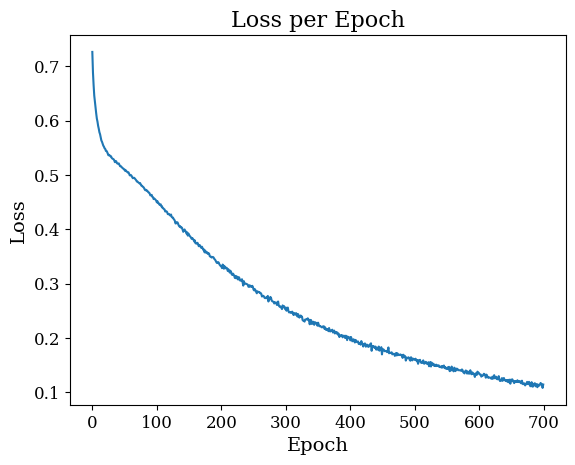

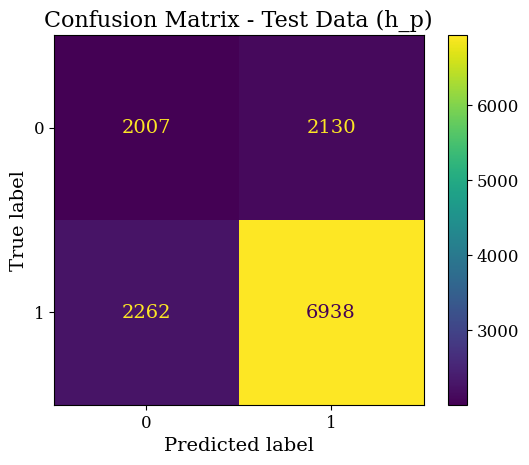

Training Accuracy h_p: 0.9995
Test Accuracy h_p: 0.6707

Training and evaluating model excluding sensitive attributes (H0)...
Epoch [100/700], Loss: 0.4554
Epoch [200/700], Loss: 0.3373
Epoch [300/700], Loss: 0.2585
Epoch [400/700], Loss: 0.2072
Epoch [500/700], Loss: 0.1702
Epoch [600/700], Loss: 0.1417
Epoch [700/700], Loss: 0.1241


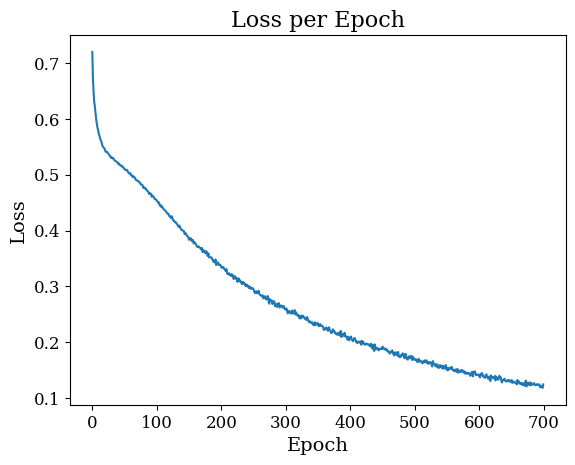

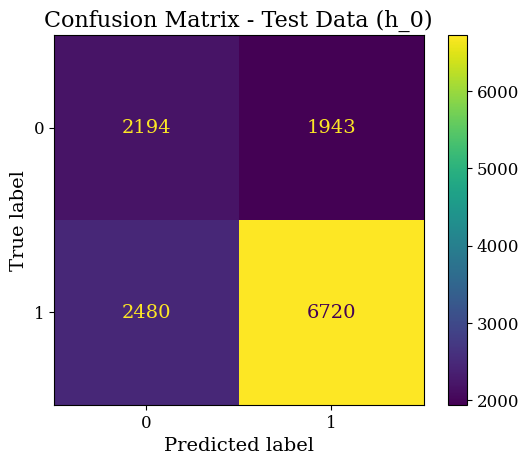

Training Accuracy h_0: 0.9989
Test Accuracy h_0: 0.6684


In [12]:
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model()

For test data:
Number of individuals in 'Female + White':  4079
Number of individuals in 'Female + NonWhite':  1676
Number of individuals in 'Male + White':  5490
Number of individuals in 'Male + NonWhite':  2092
Group Female + White - Model h_p: 0.3344, Model h_0: 0.3344, Loss difference: 0.0000
Group Female + NonWhite - Model h_p: 0.3532, Model h_0: 0.3473, Loss difference: -0.0060
Group Male + White - Model h_p: 0.3173, Model h_0: 0.3204, Loss difference: 0.0031
Group Male + NonWhite - Model h_p: 0.3317, Model h_0: 0.3432, Loss difference: 0.0115
Total loss h_p: 0.3293
Total loss h_0: 0.3316
Total loss difference: 0.0023
For training data:
Number of individuals in 'Female + White':  9582
Number of individuals in 'Female + NonWhite':  3945
Number of individuals in 'Male + White':  12810
Number of individuals in 'Male + NonWhite':  4782
Group Female + White - Model h_p: 0.0003, Model h_0: 0.0011, Loss difference: 0.0008
Group Female + NonWhite - Model h_p: 0.0003, Model h_0: 0.0010, L

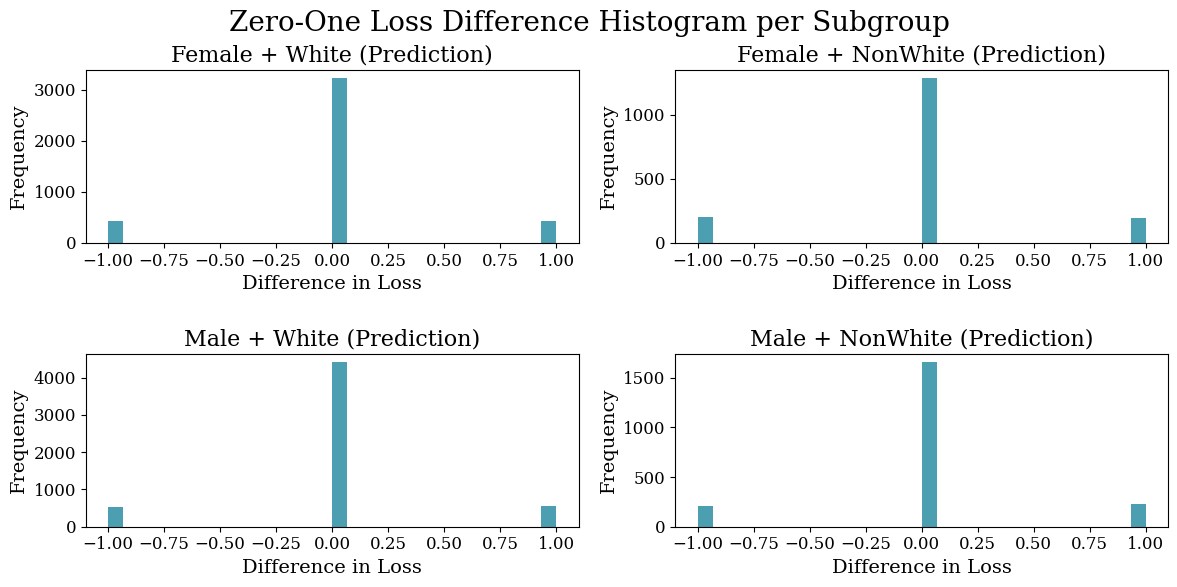

In [13]:
# Step 2: Generate predictions for both models (h_p and h_0)
y_preds_hp = predict_classification_model(model_hp, X_test_hp)  # Using the model trained with all features (h_p)
y_preds_h0 = predict_classification_model(model_h0, X_test_h0)  # Using the model trained excluding gender and race (h_0)

# Use the same true labels for both models
y_test_hp = y_test
y_test_h0 = y_test

# Step 3: Compare models by gender and race using regression cost function (mean squared error)
print("For test data:")
filters = create_gender_race_filters(X_test_hp)
print("Number of individuals in 'Female + White': ", (filters['Female + White']).sum())
print("Number of individuals in 'Female + NonWhite': ", (filters['Female + NonWhite']).sum())
print("Number of individuals in 'Male + White': ", (filters['Male + White']).sum())
print("Number of individuals in 'Male + NonWhite': ", (filters['Male + NonWhite']).sum())

# Compare model performance using the defined filters
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(
    y_preds_hp, y_preds_h0, X_test_hp, y_test_hp, y_test_h0, zero_one_loss, comprehensiveness=False
)

print("For training data:")
# Generate predictions for training data
y_preds_hp_train = predict_classification_model(model_hp, X_train_hp)
y_preds_h0_train = predict_classification_model(model_h0, X_train_h0)

# Display number of individuals in each group (based on gender + race)
filters_train = create_gender_race_filters(X_train_hp)
print("Number of individuals in 'Female + White': ", (filters_train['Female + White']).sum())
print("Number of individuals in 'Female + NonWhite': ", (filters_train['Female + NonWhite']).sum())
print("Number of individuals in 'Male + White': ", (filters_train['Male + White']).sum())
print("Number of individuals in 'Male + NonWhite': ", (filters_train['Male + NonWhite']).sum())

# True labels for training data
y_train_hp = y_train
y_train_h0 = y_train

# Compare models for training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(
    y_preds_hp_train, y_preds_h0_train, X_train_hp, y_train_hp, y_train_h0, zero_one_loss, comprehensiveness=False
)

# Step 4: Plot loss difference histograms for model predictions using mean squared error
plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, zero_one_loss, "Prediction")

In [14]:
# Step 5: Generate explanations with Integrated Gradients for test and training data
attributions_hp, _ = explain_with_ig(model_hp, X_test_hp)
attributions_h0, _ = explain_with_ig(model_h0, X_test_h0)

# Generate explanations for training data
attributions_hp_train, _ = explain_with_ig(model_hp, X_train_hp)
attributions_h0_train, _ = explain_with_ig(model_h0, X_train_h0)

Shape of attributions: torch.Size([13337, 88])
Shape of attributions: torch.Size([13337, 86])
Shape of attributions: torch.Size([31119, 88])
Shape of attributions: torch.Size([31119, 86])


For testing data explainer


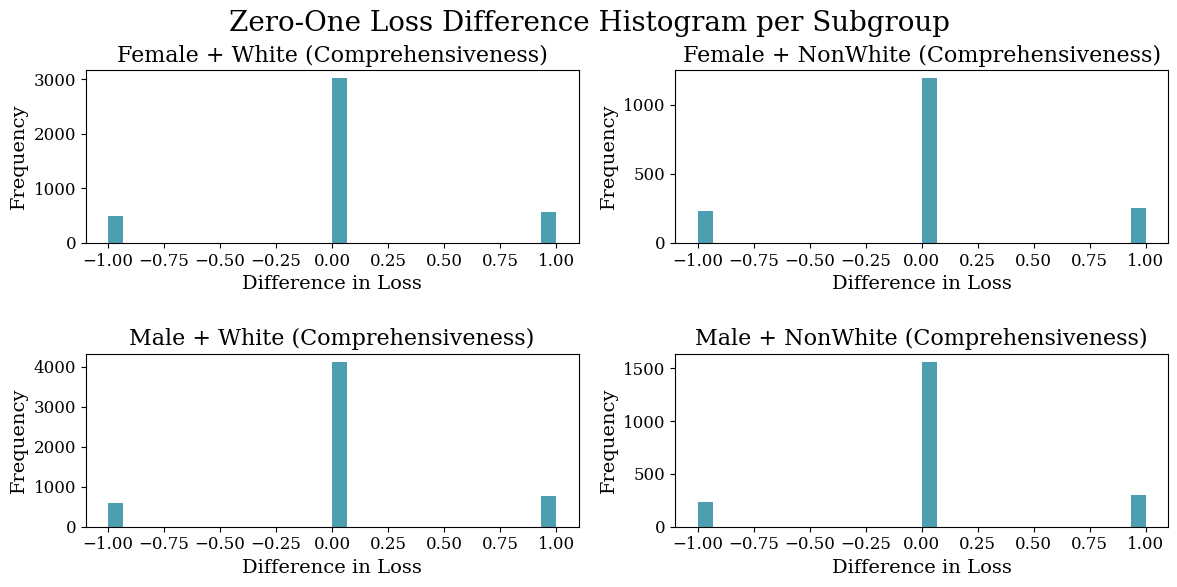

Group Female + White - Model h_p: -0.6477, Model h_0: -0.6286, Loss difference: 0.0191
Group Female + NonWhite - Model h_p: -0.6074, Model h_0: -0.5937, Loss difference: 0.0137
Group Male + White - Model h_p: -0.6632, Model h_0: -0.6326, Loss difference: 0.0306
Group Male + NonWhite - Model h_p: -0.6396, Model h_0: -0.6052, Loss difference: 0.0344
Total loss h_p: -0.6477
Total loss h_0: -0.6222
Total loss difference: 0.0256


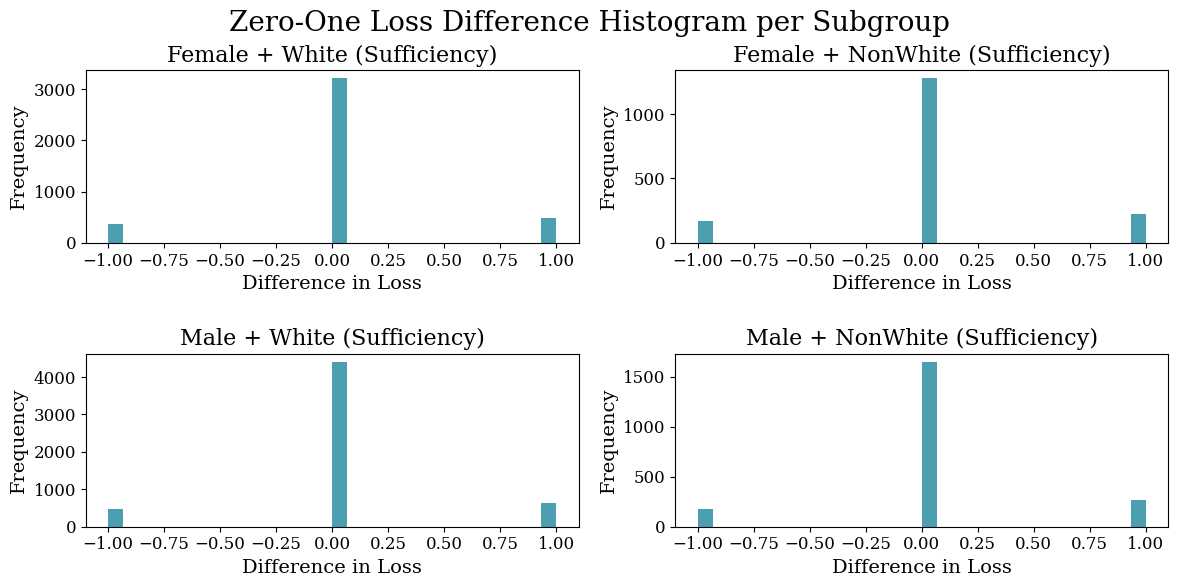

Group Female + White - Model h_p: 0.3153, Model h_0: 0.3420, Loss difference: 0.0267
Group Female + NonWhite - Model h_p: 0.3467, Model h_0: 0.3801, Loss difference: 0.0334
Group Male + White - Model h_p: 0.3095, Model h_0: 0.3375, Loss difference: 0.0281
Group Male + NonWhite - Model h_p: 0.3260, Model h_0: 0.3652, Loss difference: 0.0392
Total loss h_p: 0.3185
Total loss h_0: 0.3486
Total loss difference: 0.0301
For training data explainer
Group Female + White - Model h_p: -0.6564, Model h_0: -0.6569, Loss difference: -0.0004
Group Female + NonWhite - Model h_p: -0.6451, Model h_0: -0.6510, Loss difference: -0.0058
Group Male + White - Model h_p: -0.6682, Model h_0: -0.6636, Loss difference: 0.0046
Group Male + NonWhite - Model h_p: -0.6504, Model h_0: -0.6468, Loss difference: 0.0036
Total loss h_p: -0.6589
Total loss h_0: -0.6573
Total loss difference: 0.0016
Group Female + White - Model h_p: 0.3080, Model h_0: 0.3089, Loss difference: 0.0009
Group Female + NonWhite - Model h_p: 0.

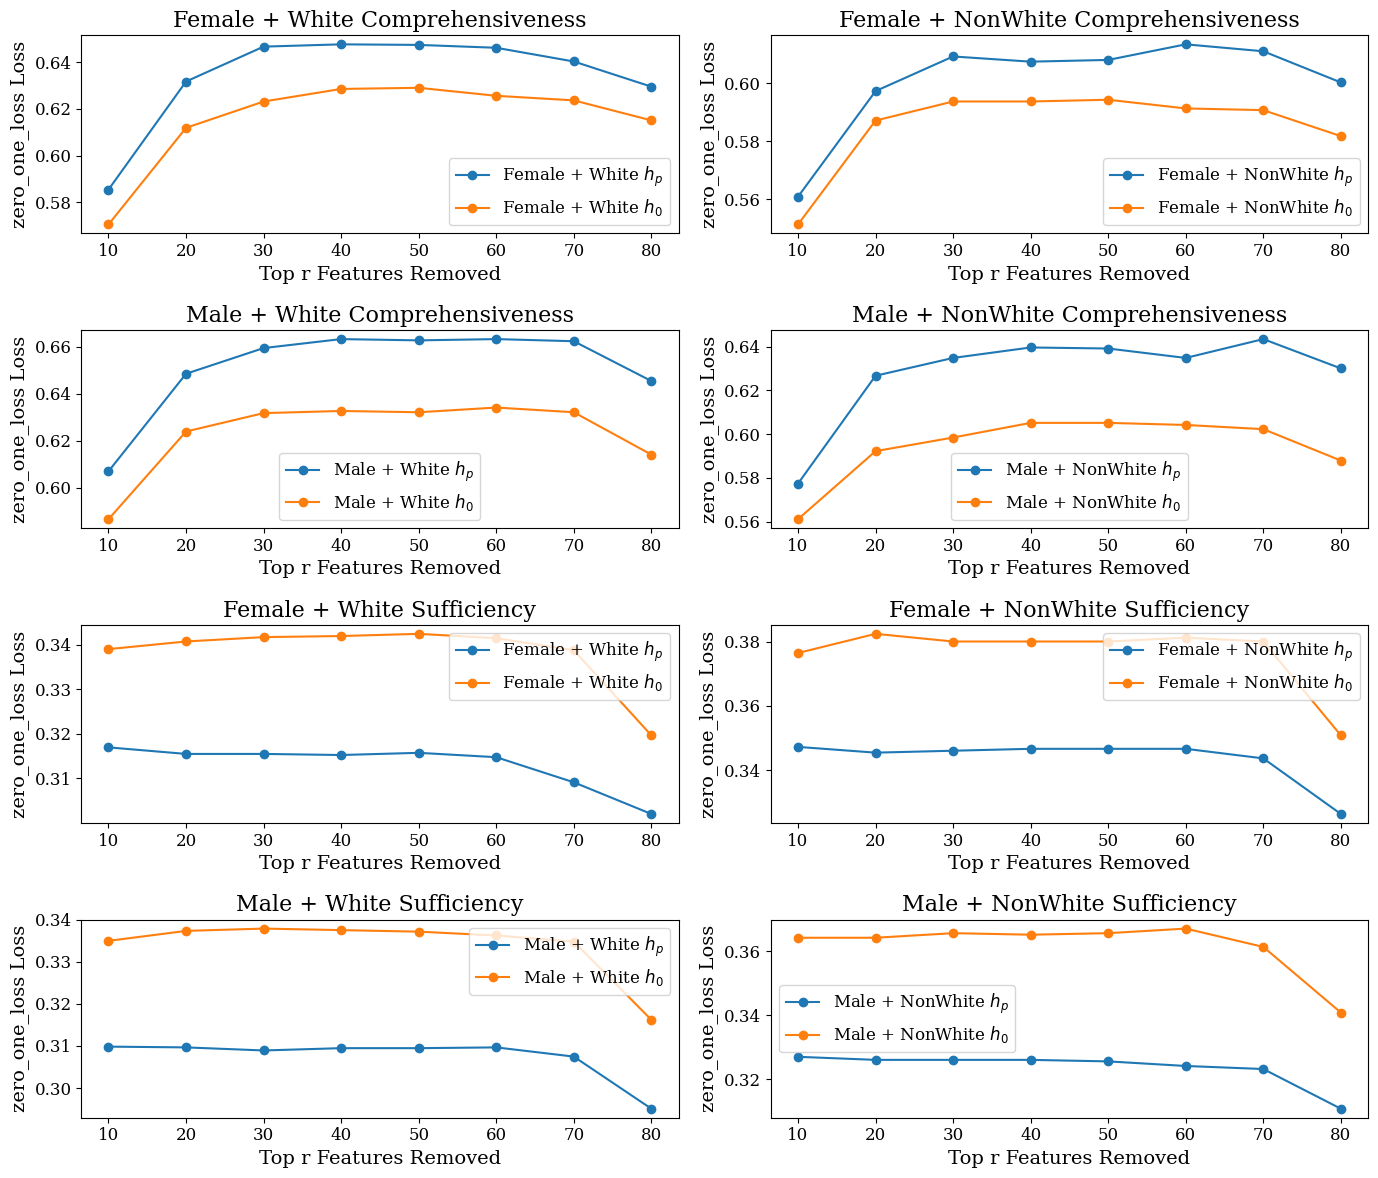

In [15]:
top_k = 40  # Adjust the number of top features to remove

# Step 6: Analyze comprehensiveness for test data
print("For testing data explainer")
comprehensiveness_preds_hp_reg = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
comprehensiveness_preds_h0_reg = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for comprehensiveness
plot_loss_difference_histogram(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Comprehensiveness")

# Compare models for comprehensiveness
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_reg, comprehensiveness_preds_h0_reg, X_test_hp, y_preds_hp, y_preds_h0, zero_one_loss, comprehensiveness=True)

# Step 7: Analyze sufficiency for test data
sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for sufficiency
plot_loss_difference_histogram(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Sufficiency")

# Compare models for sufficiency
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, zero_one_loss, comprehensiveness=False)

# Step 8: Analyze comprehensiveness for training data
print("For training data explainer")
comprehensiveness_preds_hp_train_reg = comprehensiveness(model_hp, X_train_hp, attributions_hp_train, top_k)
comprehensiveness_preds_h0_train_reg = comprehensiveness(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for comprehensiveness on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_train_reg, comprehensiveness_preds_h0_train_reg, X_train_hp, y_preds_hp_train, y_preds_h0_train, zero_one_loss, comprehensiveness=True)

# Step 9: Analyze sufficiency for training data
sufficiency_preds_hp_train = sufficiency(model_hp, X_train_hp, attributions_hp_train, top_k)
sufficiency_preds_h0_train = sufficiency(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for sufficiency on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(sufficiency_preds_hp_train, sufficiency_preds_h0_train, X_train_hp, y_preds_hp_train, y_preds_h0_train, zero_one_loss, comprehensiveness=False)

# Step 10: Plot loss differences for various values of k
ks = [10, 20, 30, 40, 50, 60, 70, 80]  # Example range of k values
plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, zero_one_loss, ks)

In [20]:
try:
    f.close()
except NameError:
    pass  # File handle 'f' may not exist or may already be closed


for key, value in globals().items():
    if not key.startswith("__"):
        try:
            pickle.dumps({key: value})
        except Exception as e:
            print(f"Cannot pickle {key}: {e}")

# Explicitly exclude problematic keys like 'f' and others
excluded_keys = {'f', 'variables_to_save', 'get_ipython', 'exit', 'quit', 'open', 'pd', 'np', 'torch', 'nn', 'optim', 'plt', 'stats', 'pickle', 'types', 'io'}

# Filter globals
variables_to_save = {
    key: value for key, value in globals().items()
    if key not in excluded_keys  # Exclude known problematic variables
    and not key.startswith("__")  # Exclude built-ins
    and not isinstance(value, types.ModuleType)  # Exclude modules
    and not isinstance(value, types.FunctionType)  # Exclude functions
    and not isinstance(value, io.IOBase)  # Exclude open file handles
}

print("Variables being saved:", list(variables_to_save.keys()))

# Save the filtered variables
with open('variables_classification.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)

Cannot pickle get_ipython: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Cannot pickle exit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Cannot pickle quit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Cannot pickle open: Can't pickle <function open at 0x7f3782d4d620>: it's not the same object as io.open
Cannot pickle pd: cannot pickle 'module' object
Cannot pickle np: cannot pickle 'module' object
Cannot pickle torch: cannot pickle 'module' object
Cannot pickle nn: cannot pickle 'module' object
Cannot pickle optim: cannot pickle 'module' object
Cannot pickle plt: cannot pickle 'module' object
Cannot pickle pickle: cannot pickle 'module' object
Cannot pickle types: cannot pickle 'module' object
Cannot pickle io: cannot pickle 'module' object
Cannot pickle f: cannot pickle '_io.BufferedWriter' object
Variables being saved: ['_ih', '_oh', '_dh', 'In', 'Out', '_

In [ ]:
# Load the variables
with open('variables_classification.pkl', 'rb') as f:
    loaded_variables = pickle.load(f)

# Update globals with loaded variables
globals().update(loaded_variables)
print("Variables loaded:", list(loaded_variables.keys()))